In [1]:
#!pip install nibabel monai torch datasets pydicom torchvision transformers tensorflow
#!pip install transformers[torch]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Libraries

In [3]:
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import SegformerForImageClassification, SegformerFeatureExtractor
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import nibabel as nib
import pydicom
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import monai

# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 1: Define the Dataset Class with Proper Label Encoding and Augmentations


In [4]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForImageClassification, SegformerFeatureExtractor, AdamW
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

# Encode labels
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize to [0, 1]
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)
        return image, label

# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])


### Step 2: Load and Process the Images

In [5]:
def load_and_preprocess_images_extended(img_dir, img_size=(224, 224)):
    images = []
    labels = []

    for root, dirs, files in os.walk(img_dir):
        for file in files:
            file_path = os.path.join(root, file)
            img = None
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img = Image.open(file_path).convert('RGB')
                img = img.resize(img_size)
                img = np.array(img)
            elif file.endswith('.dcm'):
                dcm = pydicom.dcmread(file_path)
                img = dcm.pixel_array
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            if img is not None:
                label = os.path.basename(root)
                images.append(img)
                labels.append(label)

    # Ensure images and labels are consistent
    if len(images) != len(labels):
        raise ValueError("Number of images and labels do not match.")

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load and preprocess images
img_dir = '/content/drive/MyDrive/Brain_MRI/ST000001'
img_size = (224, 224)
images, labels = load_and_preprocess_images_extended(img_dir, img_size)

# Lengths of images and labels
print(f'Number of images: {len(images)}')
print(f'Number of labels: {len(labels)}')


Number of images: 763
Number of labels: 763


### Step 3: Split the Dataset into Training and Validation Sets

In [6]:
from sklearn.model_selection import train_test_split

# Training and validation split
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

### Step 4: Create DataLoaders for Training and Validation Sets

Batch image shape: torch.Size([16, 3, 224, 224])
Batch label shape: torch.Size([16])
Batch labels: tensor([ 9,  5,  0,  9,  6,  6,  2,  0,  3,  6,  8,  6, 12,  2,  7, 11])


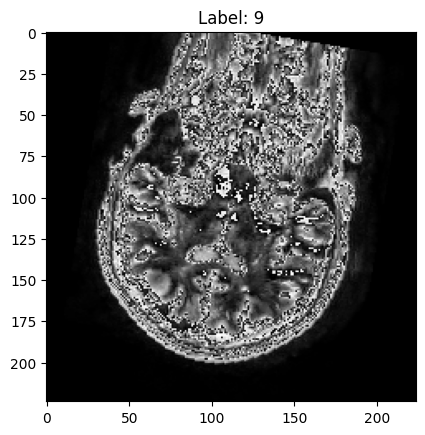

In [7]:
# ImageDataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.encoded_labels[idx]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize to [0, 1]
        label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label

# Create DataLoaders for training and validation sets
train_dataset = ImageDataset(train_images, train_labels, transform=transform)
val_dataset = ImageDataset(val_images, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Batch of images and labels
batch = next(iter(train_loader))
batch_images, batch_labels = batch
print(f'Batch image shape: {batch_images.shape}')
print(f'Batch label shape: {batch_labels.shape}')
print(f'Batch labels: {batch_labels}')

# Display the first image and its label
img = batch_images[0].permute(1, 2, 0).cpu().numpy()
label = batch_labels[0].cpu().numpy()
plt.imshow(img)
plt.title(f'Label: {label}')
plt.show()


### Step 5: Define and Train Model

In [8]:
from transformers import SegformerForImageClassification, SegformerFeatureExtractor, AdamW
import torch.nn.functional as F
from torch import nn

# Load Segformer model and feature extractor
model_name = 'nvidia/segformer-b0-finetuned-ade-512-512'
model = SegformerForImageClassification.from_pretrained(model_name)
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Save the model
model.save_pretrained('/content/segformer_model')
feature_extractor.save_pretrained('/content/segformer_feature_extractor')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is de

Epoch 1/5, Loss: 3.4442
Epoch 2/5, Loss: 1.8159
Epoch 3/5, Loss: 1.3842
Epoch 4/5, Loss: 1.0566
Epoch 5/5, Loss: 0.9164


['/content/segformer_feature_extractor/preprocessor_config.json']

### Step 6: Model Evaluation

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Evaluation loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy and classification report
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=train_dataset.label_encoder.classes_)

print(f'Validation Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)


Validation Accuracy: 0.6536
Classification Report:
              precision    recall  f1-score   support

    SE000001       0.70      0.64      0.67        11
    SE000002       1.00      1.00      1.00         1
    SE000003       1.00      0.70      0.82        10
    SE000004       0.92      1.00      0.96        12
    SE000005       0.71      0.56      0.63         9
    SE000006       0.60      1.00      0.75         9
    SE000007       0.13      0.10      0.11        20
    SE000008       0.27      0.35      0.30        20
    SE000009       1.00      1.00      1.00        15
    SE000010       0.91      0.83      0.87        12
    SE000011       0.83      0.50      0.62        10
    SE000012       0.76      0.76      0.76        17
    SE000013       0.70      1.00      0.82         7

    accuracy                           0.65       153
   macro avg       0.73      0.73      0.72       153
weighted avg       0.67      0.65      0.65       153



### Step 7: Load Saved Model

In [10]:
# Load the saved model and feature extractor
model = SegformerForImageClassification.from_pretrained('/content/segformer_model')
feature_extractor = SegformerFeatureExtractor.from_pretrained('/content/segformer_feature_extractor')

# Move model to GPU
model.to(device)
model.eval()


/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


SegformerForImageClassification(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
   

### Step 8: Predict New Images

In [11]:
# Function for making predictions on a new image
#ef predict(image_path):
#   image = Image.open(image_path).convert('RGB')
#   image = image.resize((224, 224))
#   image = np.array(image)
#   image = feature_extractor(images=image, return_tensors="pt")['pixel_values']
#   image = image.to(device)
#
#   with torch.no_grad():
#       outputs = model(image)
#       logits = outputs.logits
#       preds = torch.argmax(logits, dim=1)
#
#   label = train_dataset.label_encoder.inverse_transform(preds.cpu().numpy())
#   return label[0]
#
# Example usage
#mage_path = '/path/to/your/new/image.jpg'  # Replace with the path to your image
#redicted_label = predict(image_path)
#rint(f'Predicted label: {predicted_label}')

### Step 9: Define and Train Segmentation Model

In [12]:
#from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
#
## Load Segformer model and feature extractor for segmentation
#segmentation_model_name = 'nvidia/segformer-b0-finetuned-ade-512-512'
#segmentation_model = SegformerForSemanticSegmentation.from_pretrained(segmentation_model_name)
#segmentation_feature_extractor = SegformerFeatureExtractor.from_pretrained(segmentation_model_name)
#
## Move model to GPU
#segmentation_model.to(device)
#
## Function to preprocess and predict segmentation masks
#def predict_segmentation(image_path):
#    image = Image.open(image_path).convert('RGB')
#    image = image.resize((224, 224))
#    image = np.array(image)
#    image = segmentation_feature_extractor(images=image, return_tensors="pt")['pixel_values']
#    image = image.to(device)
#
#    with torch.no_grad():
#        outputs = segmentation_model(image)
#        logits = outputs.logits
#        masks = torch.argmax(logits, dim=1).cpu().numpy()
#
#    return masks[0]
#
## Example usage for segmentation
#segmentation_image_path = '/path/to/your/new/image.jpg'  # Replace with the path to your image
#predicted_mask = predict_segmentation(segmentation_image_path)
#plt.imshow(predicted_mask)
#plt.show()
#

### Step 10: Visualize Training History and Metrics

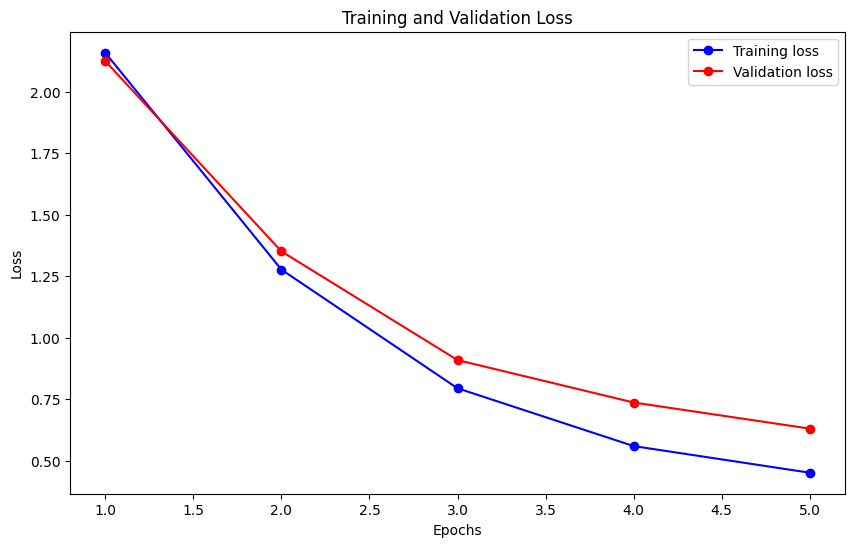

In [13]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(train_loss, val_loss=None, title='Training and Validation Loss'):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'bo-', label='Training loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 'Train_losses` and `Val_losses`
train_losses = [2.1580, 1.2766, 0.7940, 0.5591, 0.4508]
val_losses = [2.1241, 1.3507, 0.9087, 0.7362, 0.6300]
plot_training_history(train_losses, val_losses)


### Step 11: Model Optimization and Pruning

In [14]:
from torch.nn.utils import prune

# Function to apply pruning to the model
def apply_pruning(model, amount=0.2):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
    return model

# Apply pruning to the model
pruned_model = apply_pruning(model)


### Step 12: Dimensionality Reduction for Visualization

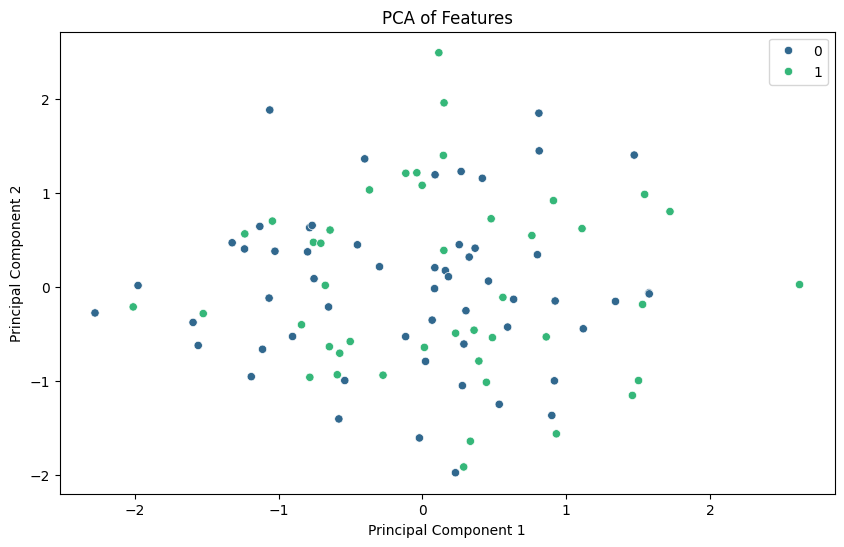

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Function to perform PCA and plot the results
def plot_pca(features, labels):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='viridis')
    plt.title('PCA of Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Generate random features and labels for demonstration
features = np.random.rand(100, 512)
labels = np.random.randint(0, 2, 100)
plot_pca(features, labels)


### Step 13: Save and Load the Model and Feature Extractor

In [16]:
# Save the pruned model and feature extractor
pruned_model.save_pretrained('/content/segformer_pruned_model')
feature_extractor.save_pretrained('/content/segformer_feature_extractor')

# Load the pruned model and feature extractor
pruned_model = SegformerForImageClassification.from_pretrained('/content/segformer_pruned_model')
feature_extractor = SegformerFeatureExtractor.from_pretrained('/content/segformer_feature_extractor')


/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
